# MATH50003 (2024–25)
# Revision Lab

In [1]:
using LinearAlgebra, SetRounding, Test

**Problem 1(a)** Simpson's rule on a single panel is given by
$$
∫_a^b f(x) {\rm d}x ≈ {b-a \over 6} \left[f(a) + 4 f\!\left({a+b \over 2}\right) + f(b) \right].
$$
Complete the implementation of `simpsonsrule` by dividing $[0,1]$ into grid points $x_0, x_1, …, x_{2n}$ with $x_k = k/(2n)$
and applying Simpson's rule on the intervals $[x_{2k-2},x_{2k}]$ for $k = 1,…,n$.

In [2]:
function simpsonsrule(f, n)
    # TODO: implement Simpsons rule
    # SOLUTION
    ret = 0.0
    for k = 1:n
        a = (2k-2)/(2n)
        h = (2k-1)/(2n) # need to evaluate at midpoint
        b = (2k)/(2n)
        ret += 1/(6n) * (f(a) + 4f(h) + f(b))
    end
    ret
    # END
end

@test simpsonsrule(exp, 1000) ≈ exp(1)-1

Test Passed

**Problem 1(b)** By computing with various values of $n$, conjecture what the convergence rate is as $n → ∞$. Is it faster than Trapezium rules $O(n^{-2})$?

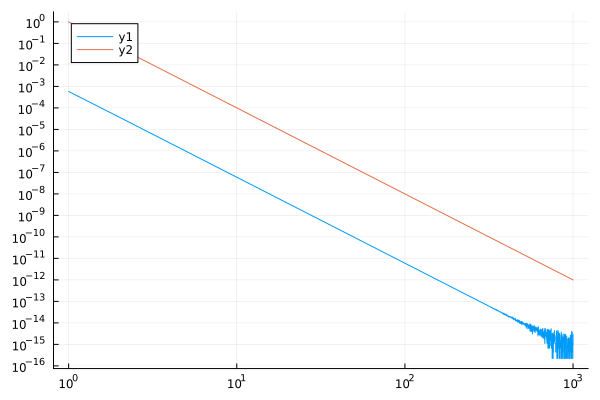

In [3]:
# TODO: vary n and deduce the converge rate, either by looking at errors or by plotting
# SOLUTION
# We can do this without plotting as follows:

(simpsonsrule(exp, 10) - (exp(1)-1))/(simpsonsrule(exp, 20) - (exp(1)-1)) # ≈ 16 = 2^4
# Since if an error is bounded by $Cn^(-4)$ then doubling $n$ would be bounded by
# $Cn^(-4)/16$, we can conjecture that the convergence it is $O(n^{-4})$, twice as good as trapezium.

# Plotting is a more robust way:
using Plots
nanabs = x -> iszero(x) ? NaN : abs(x)
errs = [nanabs((simpsonsrule(exp, n) - (exp(1)-1))) for n = 1:1000]

plot(1:1000, errs; yscale=:log10, xscale=:log10, xticks=10 .^ (0:3), yticks=10.0 .^ (-(0:16)))
plot!(1:1000, (1:1000) .^ (-4))

# We confirm its $O(n^{-4})$



# END

**Problem 2** Consider a 3-term divided-difference approximation
$$
f'(x) ≈ {5f(x+2h) - 3f(x) - 2f(x-h) \over 12h}
$$
Implement this in the following function.

In [4]:
function threeterm_divideddifference(f, x, h)
    # TODO: Implement the above divided-difference formula
    # SOLUTION
    (5f(x+2h) - 3f(x) - 2f(x-h))/(12h)
    # END
end
@test threeterm_divideddifference(exp, 0, 0.0000001) ≈ 1 atol=1E-5

Test Passed

**Problem 3** Using the following simplified `Dual` implementation, consider a double-dual number
like `Dual(Dual(a,b), Dual(c,d))`. By choosing `a`, `b`, `c` and `d`, construct the function `secondderivative(f, x)`
that computes the second derivative of a function. Hint: it might help to think of a double-dual number as
$(a + b*ε) + δ*(c + d*ε)$ where $ε^2 = δ^2 = 0$.

In [5]:
struct Dual
    a
    b
end

import Base: +, *, exp
function +(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a+c, b+d)
end
function *(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a*c, b*c + a*d)
end
exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)


function secondderivative(f, x)
    # TODO: compute the second derivative of f using a double-dual number.
    # SOLUTION
    # This requires a bit of pen-and-paper deduction. A double-dual can be represented as
    # a + bε + δ*(c+dε) = a + bε + cδ + dεδ
    # where ε^2 == δ^2 == 0.
    # We want to choose a,b,c,d so that we can recover the second derivative for all polynomials.
    # Note that:
    # (a + bε + δ*(c+dε))^k == (a+bε)^k + k*δ*(c+dε)*(a+bε)^(k-1)
    #  == a^k + kba^(k-1)*ε + kc*a^(k-1)*δ + (c*k*(k-1)*a^(k-2) + d*a^(k-1))*ε*δ
    # By setting b = c = 1 and d = 0 we see that this satisfies
    #  (x + ε + δ)^k = x^k + k*x^(k-1)*ε + k*x^(k-1)*δ + k*(k-1)*x^(k-2)*ε*δ
    # that is, the dual of the dual part equals the second derivative of x^k
    f(Dual(Dual(x, 1), Dual(1, 0))).b.b
    # END
end

f = x -> exp(x*exp(x))
@test secondderivative(f, 0) ≈ 3

Test Passed

**Problem 4** Implement the following function
`primedigits` that constructs a positive `Float64` of the form $2^q * (1.b_1…b_S)$
where the exponent is specified by `q` and has significand
bits
$$
b_k = \begin{cases}
    1 & k\hbox{ is prime} \\
    0 & \hbox{otherwise}
    \end{cases}
$$
Hint: use the `gcd` function to determine if a number is prime.

In [6]:
function primedigits(q)
    # TODO: return a Float64 with the specified bits.
    # SOLUTION
    # significand has 52 bits. we can either do it by hand or create a string:
    function isprime(k) # quick-and-dirty test for prime
        if k ≤ 1
            return false
        end
        for j=1:k-1
            if gcd(k, j) ≠ 1
                return false
            end
        end
        return true
    end

    ret = "1" # leading coefficient

    for k = 1:52
        if isprime(k)
            ret *= "1"
        else
            ret *= "0"
        end
    end

    sig = 2.0^(-52) * parse(Int, ret; base=2)

    2.0^(q) * sig
    # END
end

@test primedigits(3) == 11.317460078808892

Test Passed

**Problem 5** Implement the `sqrt` function with correctly rounded interval arithmetic.

In [7]:
struct Interval # represents the set [a,b]
    a # left endpoint
    b # right endpoint
end

Interval(x) = Interval(x,x) # Support Interval(1) to represent [1,1]

import Base: sqrt, in
in(x, X::Interval) = X.a ≤ x ≤ X.b

function sqrt(X::Interval)
    a,b = promote(X.a, X.b) # make sure all are the same type
    T = typeof(a)
    # TODO: implement sqrt by correctly rounding the computation.
    # SOLUTION
    α = setrounding(T, RoundDown) do
        sqrt(a)
    end
    β = setrounding(T, RoundUp) do
        sqrt(b)
    end
    Interval(α, β)
    # END
end

@test sqrt(big(2.0)) in sqrt(Interval(2.0))

Test Passed

**Problem 6** Implement `reversecholesky(A)` that returns an upper-triangular matrix `U` such that `U*U' ≈ A`.
You may assume the input is symmetric positive definite and has `Float64` values. You must not use the inbuilt `cholesky`
function or in any other way reduce the problem to a standard Cholesky factorisation.

In [8]:
function reversecholesky(A)
    n,m = size(A)
    if n ≠ m
        error("Matrix must be square")
    end
    if A ≠ A'
        error("Matrix must be symmetric")
    end
    U = UpperTriangular(zeros(n,n))
    # TODO: populate U so that U'U ≈ A
    # SOLUTION
    Aⱼ = copy(A)
    for j = n:-1:1 # 3 points for recognising it needs to start at bottom right
        α,𝐯 = Aⱼ[j,j],Aⱼ[1:j-1,j]
        if α ≤ 0
            error("Matrix is not SPD") # this error is optional
        end
        U[j,j] = sqrt(α)
        U[1:j-1,j] = 𝐯/sqrt(α) # 4 points if this vector is chosen

        # induction part, 2 points if correct
        Aⱼ = Aⱼ[1:j-1,1:j-1] - 𝐯*𝐯'/α
    end
    # END
    U
end

A = [2 1 0; 1 2 1; 0 1 2]
U = reversecholesky(A)
@test U*U' ≈ A

Test Passed

**Problem 7(a)**  Construct a reverse Householder reflection, that gives an orthogonal matrix
$Q$ such that, for $𝐱 ∈ ℝ^n$,
$$
𝐱^⊤ Q = \|𝐱\|𝐞_1^⊤.
$$

In [9]:
function reversehouseholderreflection(x)
    # TODO: implement a Householder reflection that acts on the left
    # SOLUTION
    # This is somewhat of a trick question: if we transpose the above
    # we see its just exactly a Householder reflection
    y = copy(x)
    y[1] -= norm(y)
    w = y / norm(y)
    I - 2 * w * w'
    # END
end

x = randn(5)
Q = reversehouseholderreflection(x)
@test x'Q ≈ [norm(x) zeros(1,4)]

Test Passed

**Problem 7(b)**
Complete the function `lq(A)` that
returns a LQ factorisation, that is, `A = LQ` where  `L` is lower triangular and `Q` is an orthogonal
matrix. You may assume that `A` is a square `Matrix{Float64}`.  Do not manipulate the problem
to reduce it to a standard QR factorisation.

In [10]:
function lq(A)
    m,n = size(A)
    m == n || error("not square")
    # TODO Create Q and L such that A = L*Q, Q'Q == I and L is lower triangular
    # SOLUTION
    L = copy(A)
    Q = Matrix(1.0I, n, n)
    for k = 1:n-1
        Qₖ =  reversehouseholderreflection(L[k, k:end])
        L[k:end, k:end] = L[k:end, k:end] * Qₖ
        Q[k:end, :] = Qₖ * Q[k:end, :]
    end
    L,Q
    # END
end

A = [1.0 2 3; 1 4 9; 1 1 1]
L,Q = lq(A)
@test Q'Q ≈ I
@test L*Q ≈ A
@test L ≈ tril(L) # it is acceptable to have small non-zero entries in L

Test Passed

**Problem 8** Complete the function `lagrangebasis(g, k, x)` where `g` is a vector of grid
points, that computes the Lagrange basis function at the point `x`. You may assume all numbers
are `Float64`.

In [11]:
function lagrangebasis(g::AbstractVector, k, x)
    n = length(g) # number of points
    ## TODO: compute ℓ_k(x) corresponding to the grid g
    # SOLUTION
    ret = 1.0
    for j = 1:n
        if j ≠ k
            ret *= (x-g[j])/(g[k]-g[j])
        end
    end
    ret
    # END
end

g = 1:5
@test lagrangebasis(g, 2, 2) == 1
@test lagrangebasis(g, 2, 3) == lagrangebasis(g, 2, 4) ==  0
@test lagrangebasis(g, 3, 0.1) ≈ 8.169525

Test Passed

**Problem 9(a)**  Consider the Schrödinger equation with quadratic oscillator:
$$
u(-L) = u(L) = 0, -u'' + x^2 u = f(x)
$$
Use row-eliminations to recast the tridiagonal finite-difference discretisation as a symmetric tridiagonal
system, solved via the `SymTridiagonal` type,.

In [12]:
function schrodingersolve(n, L, f)
    x = range(-L,L;length=n+1) # discretisation grid
    # TODO: Implement finite differences using a SymTridiagonal matrix, by using the knowledge of the solution at ±L.
    # SOLUTION
    # In the standard triangular discretisation, we can
    h = step(x)
    A = SymTridiagonal(2/h^2 .+  x[2:end-1].^2, fill(-1/h^2, n-2))
    [0; A \ f.(x[2:end-1]); 0]
    # END
end

f = x-> 2exp(-x^2) - 3exp(-x^2)*x^2
n,L = 10000,10
x = range(-L,L;length=n+1)
@test schrodingersolve(n, L, f) ≈ exp.(-x.^2) atol=1E-4

Test Passed

**Problem 9(b)** The `eigvals` function computes eigenvalues of a matrix. Use this alongside the
symmetric diagonal discretisation to approximate $λ$ such that
$$
u(-L) = u(L) = 0, -u'' + x^2 u = λ u
$$
has a non-zero solution (i.e., an eigenvalue of the differential equation).
Can you conjecture their exact value if $L → ∞$?

In [13]:
function shrodingereigvals(n, L)
    x = range(-L,L;length=n+1) # discretisation grid
    # TODO: Use eigvals with a SymTridiagonal discretisation to approximate the eigenvalues of a Schrödinger operator
    # SOLUTION
    h = step(x)
    eigvals(SymTridiagonal(2/h^2 .+  x[2:end].^2, fill(-1/h^2, n-1)))
    # END
end

# TODO: add experiments and a comment where you conjecture the true eigenvalues.
# SOLUTION

shrodingereigvals(10_000, 100) # the eigvals are approx 1, 3, 5, …
# Conjecture: 1+2k are the true eigenvalues eigenvalue.
# END

10000-element Vector{Float64}:
     0.999974999411461
     2.9998749944777834
     4.999674978137263
     6.999374943200275
     8.998974881843267
    10.998474786901676
    12.997874650459854
    14.997174465422827
    16.99637422398576
    18.995473918774103
     ⋮
 19733.754464947197
 19768.974991312058
 19772.94444509766
 19811.91224453501
 19815.88747181103
 19860.58490667299
 19864.566666429502
 19920.16566952343
 19924.155408228642

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*